In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from collections import defaultdict


from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

from matplotlib.patches import Ellipse

In [2]:
data = pd.read_excel('consumption.xlsx')
data.describe()

,id,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,220.500000,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,127.161315,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,110.750000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,220.500000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,330.250000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,440.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [3]:
data.head()

,id,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,1,12669,9656,7561,214,2674,1338
1,2,7057,9810,9568,1762,3293,1776
2,3,6353,8808,7684,2405,3516,7844
3,4,13265,1196,4221,6404,507,1788
4,5,22615,5410,7198,3915,1777,5185


In [4]:
data.isna().sum()

id                  0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicatessen        0
dtype: int64

In [5]:
data.duplicated().sum()

np.int64(0)

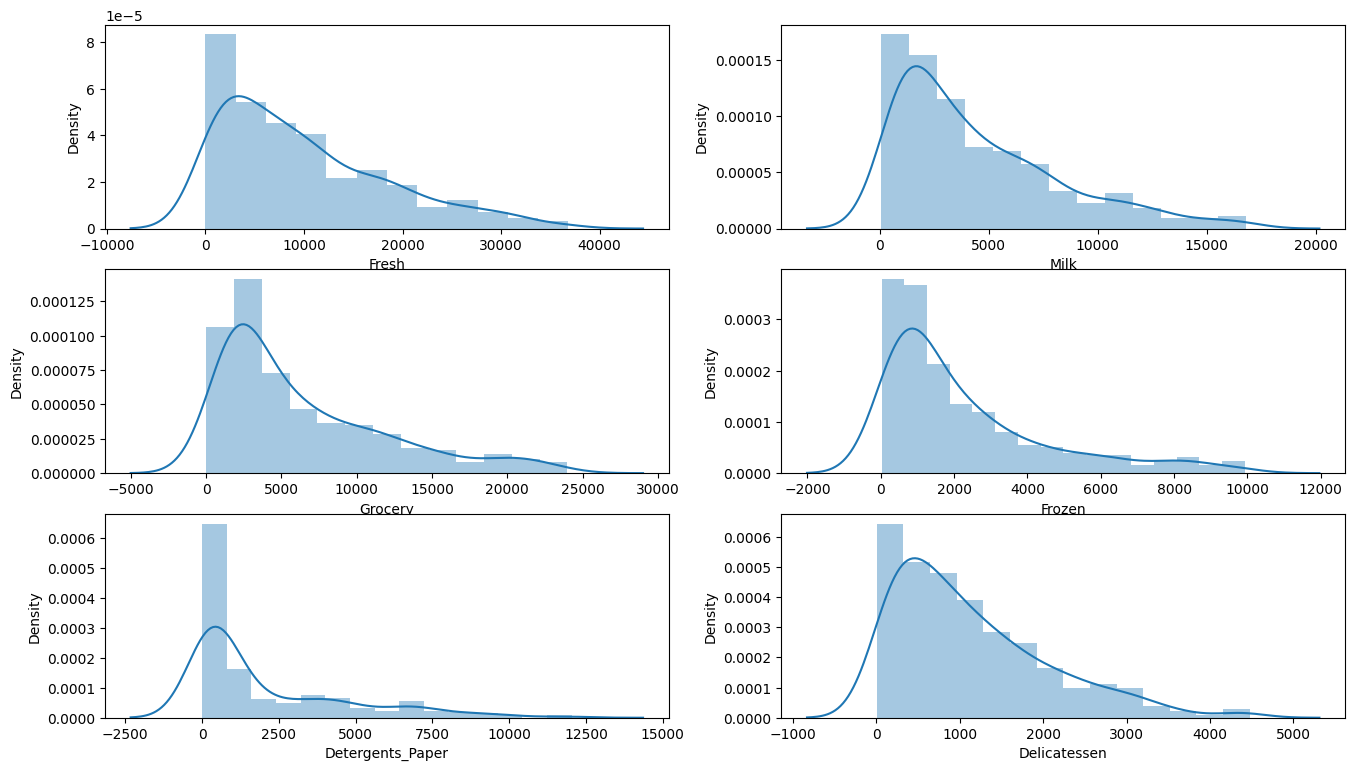

In [6]:
# plot the distribution of the each feature
fig = plt.figure(figsize=(16, 9))

for i, col in enumerate(list(data)[1:]):
    plt.subplot(321+i)
    q95 = np.percentile(data[col], 95)
    sns.distplot(data[data[col] <q95][col])
plt.show()

In [7]:
features = data[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicatessen']]

ids = []
# remove outliers
for i in list(features.columns):
    q1 = np.percentile(features[i], 25)
    q3 = np.percentile(features[i], 75)
    # determine an interval of the remaining data
    interval = 1.6 * (q3-q1) / 2
    # get the margin of data
    low = q1 - interval
    high = q3 +interval
    # get the id of data which don't lie in the interval
    ids.extend(list(features[(features[i] <= low) | (features[i] >= high)].index))
ids = list(set(ids))
# drop all the data which don't lie in the interval
features = features.drop(ids)

In [8]:
sub_data = data[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicatessen']]
for i in list(sub_data.columns):
    Q1 = sub_data[i].quantile(0.25)
    Q3 = sub_data[i].quantile(0.75)
    IQR = Q3 - Q1
    sub_data = sub_data[(sub_data[i] > Q1 - 1.5 * IQR) & (sub_data[i] < Q3 + 1.5 * IQR)] # (318, 6)


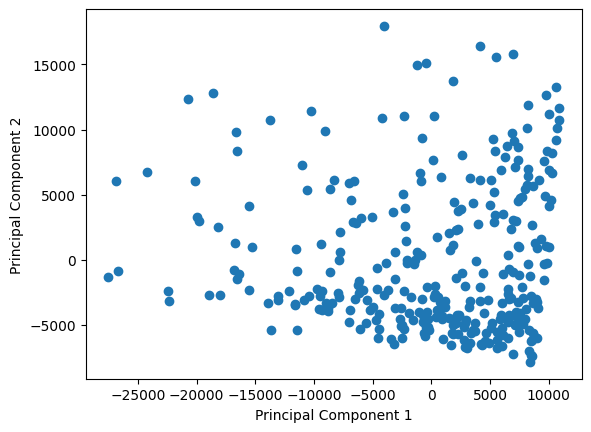

In [17]:
# PCA with eigen value
# Normalize features
sub_data -= np.mean(sub_data, axis=0)

# Compute covariance matrix and perform PCA
# covariance matrix
cov = np.cov(sub_data.transpose())
eigvals, eigvecs = np.linalg.eig(cov)
pca_mat = eigvecs[:, :2]
pca_data = np.dot(sub_data, pca_mat)
pca_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])

# Scatter plot
plt.scatter(pca_df['PC1'], pca_df['PC2'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()



In [10]:
print('The information included in the first 2 PCs: {:.2%}'.format(np.sum(eigvals[:2] / np.sum(eigvals))))

The information included in the first 2 PCs: 92.80%


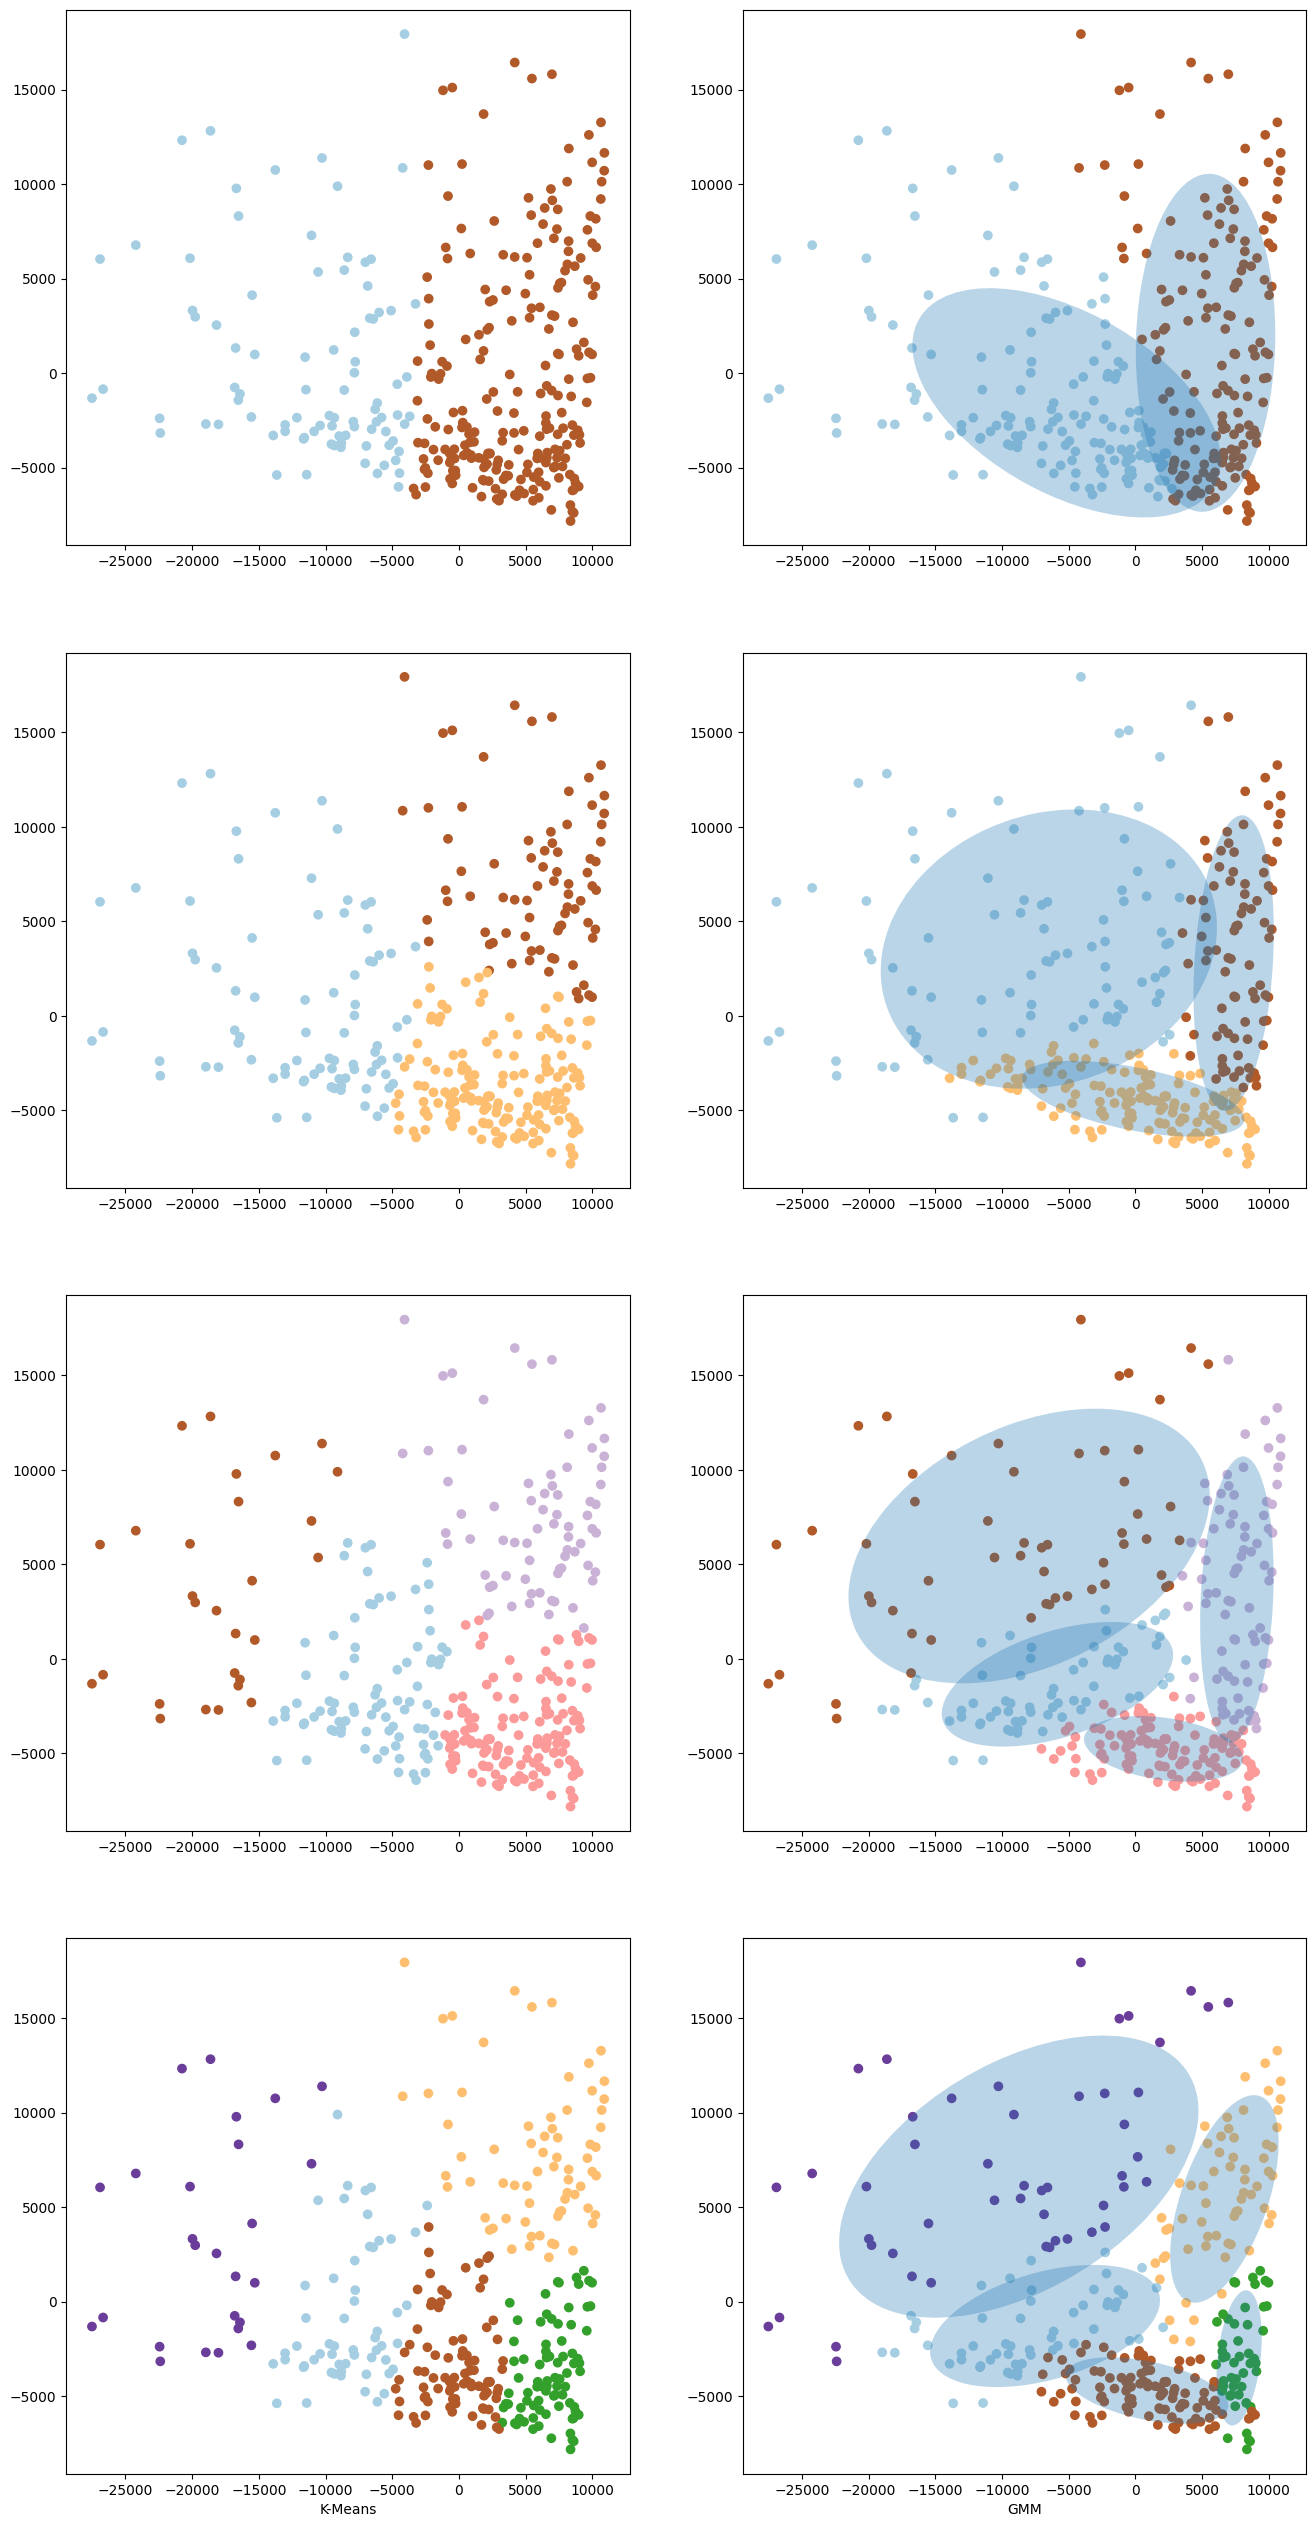

In [ ]:

# Helper function to get covariance matrix for each type
def get_covariance_matrix(gmm, n):
    if gmm.covariance_type == 'full':
        return gmm.covariances_[n][:2, :2]
    elif gmm.covariance_type == 'tied':
        return gmm.covariances_[:2, :2]
    elif gmm.covariance_type == 'diag':
        return np.diag(gmm.covariances_[n][:2])
    elif gmm.covariance_type == 'spherical':
        return np.eye(2) * gmm.covariances_[n]

# Draw the trust region for each Gaussian component
def make_ellipse(gmm, ax, k):
    for n in range(k):
        covariances = get_covariance_matrix(gmm, n)

        # Eigen decomposition
        eigvals, eigvecs = np.linalg.eigh(covariances)
        angle = np.degrees(np.arctan2(eigvecs[0, 1], eigvecs[0, 0]))  # Get angle in degrees
        width, height = 2 * np.sqrt(2) * np.sqrt(eigvals)             # Scaled eigenvalues for ellipse width and height

        # Create and add the ellipse to the axis
        ell = Ellipse(xy=gmm.means_[n, :2], width=width, height=height, angle=(angle + 180) % 360)
        ax.add_patch(ell)
        ell.set_alpha(0.3)



score_kmean = []
score_gmm = []
random_state = 666
n_cluster = np.arange(2, 6) # 2, 3, 4, 5
fig = plt.figure(figsize=(16, 32))

for i, k in zip([0, 2, 4, 6], n_cluster):
    # train K-Means Model
    kmeans = KMeans(n_clusters=k, random_state=random_state)
    clsuter_km = kmeans.fit_predict(pca_data)
    score_kmean.append(silhouette_score(pca_data, clsuter_km))

    # train Gaussian Mixture Model
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=random_state)
    cluster_gmm = gmm.fit(pca_data).predict(pca_data)
    score_gmm.append(silhouette_score(pca_data, cluster_gmm))

    # draw scatter plots and implement the clustering result inside
    ax = plt.subplot(421 + i)
    ax.scatter(pca_df['PC1'], pca_df['PC2'], c=clsuter_km, cmap=plt.cm.Paired)
    if i == 6:
        ax.set_xlabel('K-Means')
    ax = plt.subplot(421+1+i)
    ax.scatter(pca_df['PC1'], pca_df['PC2'], c=cluster_gmm, cmap=plt.cm.Paired)
    make_ellipse(gmm, ax, k)
    if i == 6:
        ax.set_xlabel('GMM')
plt.show()

In [47]:
scores = defaultdict(list)

for k in np.arange(2, 12):
    kmeans = KMeans(n_clusters=k, random_state=42)
    pred_km = kmeans.fit_predict(pca_df)
    scores["score_km"].append(silhouette_score(pca_df, pred_km))

    gmm = GaussianMixture(n_components=k, covariance_type="full", random_state=42)
    pred_gmm = gmm.fit_predict(pca_df)
    scores["score_gmm"].append(silhouette_score(pca_df, pred_gmm))

df_scores = pd.DataFrame(scores)
df_scores["k"] = np.arange(2, 12)
df_scores


,score_km,score_gmm,k
0,0.454550,0.370185,2
1,0.448536,0.293565,3
2,0.425114,0.275320,4
3,0.420965,0.332257,5
4,0.382809,0.272283,6
5,0.391867,0.310629,7
6,0.391750,0.356714,8
7,0.404696,0.347892,9
8,0.396405,0.331078,10
9,0.385452,0.332626,11


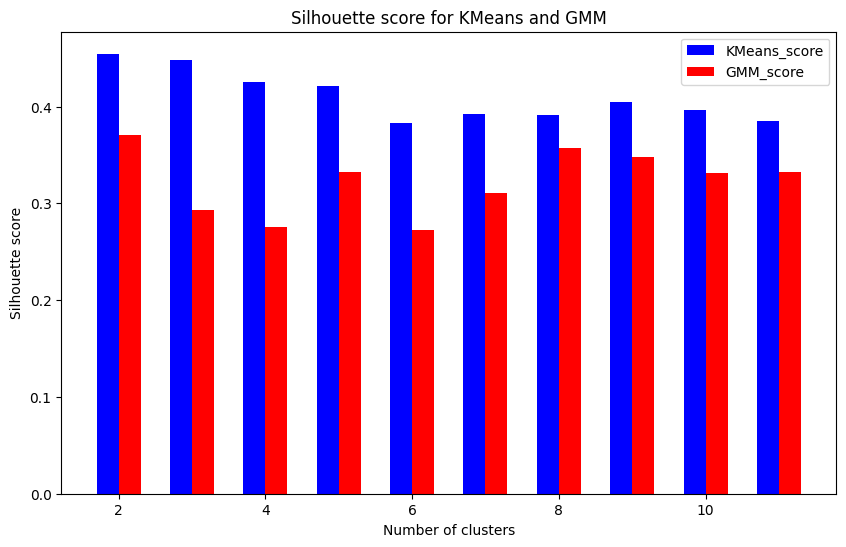

In [44]:
plt.figure(figsize=(10, 6))
plt.bar(df_scores["k"] - 0.15, df_scores["score_km"], width=0.3, facecolor='blue', label="KMeans_score")
plt.bar(df_scores["k"] + 0.15, df_scores["score_gmm"], width=0.3, facecolor='red', label="GMM_score")
plt.legend()
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.title("Silhouette score for KMeans and GMM")
plt.show()